<a href="https://colab.research.google.com/github/ksdkamesh99/LowLightEnhancer/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
cd /content/drive/My Drive/LowLightEnhancement

/content/drive/My Drive/LowLightEnhancement


In [87]:
import tensorflow as tf
import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [88]:
img_high=np.load("image_high.npy")

In [89]:
img_low=np.load("image_low.npy")

In [197]:
img_low=img_low/255
img_high=img_high/255

In [198]:
img_high.shape

(1485, 96, 96, 3)

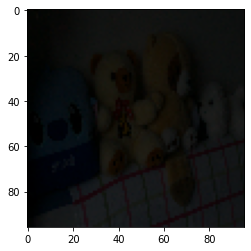

In [199]:
plt.imshow(img_low[0])

## Illumination Mask Network

In [293]:
input_layer_1=keras.layers.Input(shape=(96,96,3))

In [294]:
top=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(96,96,3),activation='relu')(input_layer_1)
top=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(top)

In [295]:

top.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'conv2d_94/Relu:0' shape=(None, 92, 92, 64) dtype=float32>>

In [296]:

bottom_inp=input_layer_1
bottom_resize=tf.keras.layers.Lambda(
    lambda img: tf.image.resize(img,(144,144),method='nearest',antialias=True)
)(bottom_inp)

In [297]:
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(96,96,3),activation='relu')(bottom_resize)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(bottom)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(bottom)


In [298]:
bottom.get_shape()

TensorShape([None, 138, 138, 64])

In [299]:
bottom=keras.layers.experimental.preprocessing.Resizing(92,92,interpolation='nearest')(bottom)

In [300]:
bottom.get_shape()

TensorShape([None, 92, 92, 64])

In [301]:
top.get_shape()

TensorShape([None, 92, 92, 64])

In [302]:
merged=keras.layers.concatenate([top,bottom])

In [303]:
merged

<tf.Tensor 'concatenate_24/concat:0' shape=(None, 92, 92, 128) dtype=float32>

In [304]:
merged=keras.layers.Conv2D(32,kernel_size=(7,7),activation='relu')(merged)
merged=keras.layers.Conv2D(8,kernel_size=(1,1),activation='relu')(merged)
merged=keras.layers.Conv2D(1,kernel_size=(5,5),activation='relu')(merged)

In [305]:
merged.get_shape()

TensorShape([None, 82, 82, 1])

In [306]:
model_illumination_mask=keras.models.Model(inputs=input_layer_1,outputs=merged)

In [307]:
model_illumination_mask.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_66 (Lambda)              (None, 144, 144, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 142, 142, 64) 1792        lambda_66[0][0]                  
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 140, 140, 64) 36928       conv2d_95[0][0]                  
______________________________________________________________________________________

# Illumination Map 

In [308]:
merged=keras.layers.experimental.preprocessing.Resizing(96,96,interpolation='nearest')(merged)

In [309]:
merged.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'resizing_43/resize/ResizeNearestNeighbor:0' shape=(None, 96, 96, 1) dtype=float32>>

In [310]:
input_layer_2=keras.layers.Input(shape=(96,96,3))

In [311]:
merged=keras.layers.Concatenate()([input_layer_2,merged])

In [312]:
merged

<tf.Tensor 'concatenate_25/concat:0' shape=(None, 96, 96, 4) dtype=float32>

In [313]:
def ieb(input_feature):
  ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu')(input_feature)
  ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu')(ieb1)
  max_pool=keras.layers.GlobalMaxPooling2D()(ieb1)
  avg_pool=keras.layers.GlobalAveragePooling2D()(ieb1)
  dense1=keras.layers.Dense(8,activation='relu')
  dense2=keras.layers.Dense(32,activation='sigmoid')
  max_pool=dense1(max_pool)
  max_pool=dense2(max_pool)
  avg_pool=dense1(avg_pool)
  avg_pool=dense2(avg_pool)
  max_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(max_pool)
  avg_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(avg_pool)
  channel=keras.layers.Add()([max_pool,avg_pool])
  ieb1=keras.layers.Multiply()([ieb1,channel])
  max_pool_s=tf.keras.layers.Lambda(
    lambda x: keras.backend.max(x,axis=3,keepdims=True))(ieb1)
  avg_pool_s=keras.layers.Lambda(
    lambda x: keras.backend.mean(x,axis=3,keepdims=True))(ieb1)
  concat_slayers=keras.layers.Concatenate(axis=3)([avg_pool_s,max_pool_s])
  spacial=keras.layers.Conv2D(1,7,activation='sigmoid')(concat_slayers)
  spacial=keras.layers.experimental.preprocessing.Resizing(92,92,interpolation='nearest')(spacial)
  ieb1=keras.layers.Multiply()([ieb1,spacial])
  ieb1=keras.layers.BatchNormalization()(ieb1)
  ieb1=keras.layers.Activation('relu')(ieb1)
  ieb1=keras.layers.experimental.preprocessing.Resizing(96,96,interpolation='nearest')(ieb1)
  return ieb1


  



In [314]:
ieb_1=ieb(merged)

In [315]:
ieb_2=ieb(ieb_1)

In [316]:
ieb_3=ieb(ieb_2)

In [317]:
ieb_4=ieb(ieb_3)

In [318]:
ieb_5=ieb(ieb_4)

In [319]:
added_ieb=keras.layers.concatenate([ieb_1,ieb_2,ieb_3,ieb_4,ieb_5])

In [320]:
added_ieb

<tf.Tensor 'concatenate_31/concat:0' shape=(None, 96, 96, 160) dtype=float32>

In [321]:

impnet=keras.layers.Conv2D(32,(7,7),activation='relu')(added_ieb)

In [322]:
impnet=keras.layers.Conv2D(8,(1,1),activation='relu')(impnet)

In [323]:
impnet=keras.layers.Conv2D(1,(5,5),activation='sigmoid')(impnet)

In [324]:
impnet=keras.layers.experimental.preprocessing.Resizing(96,96,interpolation='nearest')(impnet)

In [325]:
impnet

<tf.Tensor 'resizing_54/resize/ResizeNearestNeighbor:0' shape=(None, 96, 96, 1) dtype=float32>

# S/L Block 

In [326]:
'''impnet=keras.layers.Lambda(
    lambda x: x+keras.backend.constant(0.001)
)(impnet)'''

'impnet=keras.layers.Lambda(\n    lambda x: x+keras.backend.constant(0.001)\n)(impnet)'

In [327]:
input_layer_3=keras.layers.Input(shape=(96,96,3))

In [328]:
s_l=keras.layers.Lambda(
    lambda input:input[0]/input[1]
)([input_layer_3,impnet])

In [329]:
s_l

<tf.Tensor 'lambda_87/truediv:0' shape=(None, 96, 96, 3) dtype=float32>

# Correction Network

In [334]:
def correction_network(input_feature):
  conv1=keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu')(input_feature)
  conv2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu')(conv1)
  conv3=keras.layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu')(conv2)
  conv4=keras.layers.Conv2D(8,kernel_size=(3,3),strides=(1,1),activation='relu')(conv3)
  conv5=keras.layers.Conv2D(3,kernel_size=(3,3),strides=(1,1),activation='sigmoid')(conv4)
  conv5=keras.layers.experimental.preprocessing.Resizing(96,96,interpolation='nearest')(conv5)
  return conv5

In [335]:
final_output=correction_network(s_l)

# Custom Loss Function

In [336]:
import loss as l

In [337]:
import keras.backend as K

In [338]:
def enhancement_loss(x,y):
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  norm=tf.norm(x-y)
  return norm

In [339]:
enhancement_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=78.62597>

In [340]:

def color_loss(x,y):
  
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  cosine_loss = keras.losses.CosineSimilarity()(x,y)
  colorloss=1-cosine_loss
  return colorloss

In [341]:
color_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.9773979>

In [342]:
sobelFilter = K.variable([[[[1.,  1.]], [[0.,  2.]],[[-1.,  1.]]],
                      [[[2.,  0.]], [[0.,  0.]],[[-2.,  0.]]],
                      [[[1., -1.]], [[0., -2.]],[[-1., -1.]]]])


In [343]:
def expandedSobel(inputTensor):
    inputChannels = K.reshape(K.ones_like(inputTensor[0,0,0,:]),(1,1,-1,1))
    return sobelFilter * inputChannels



In [344]:
def squareSobelLoss(yTrue,yPred):
  
  yTrue=K.cast(yTrue,dtype='float32')
  yPred=K.cast(yPred,dtype='float32')
  filt = expandedSobel(yTrue)
  squareSobelTrue =K.square(K.depthwise_conv2d(yTrue,filt))
  squareSobelPred =K.square(K.depthwise_conv2d(yPred,filt))
  newShape = K.shape(squareSobelTrue)
  newShape = K.concatenate([newShape[:-1],
                              newShape[-1:]//2,
                              K.variable([2],dtype='int32')])
  squareSobelTrue = K.sum(K.reshape(squareSobelTrue,newShape),axis=-1)
  squareSobelPred = K.sum(K.reshape(squareSobelPred,newShape),axis=-1)
  return K.mean(K.abs(squareSobelTrue - squareSobelPred))


In [345]:

def max_rgb_filter(img):
  # img=tf.keras.preprocessing.image.img_to_array(img)
  
  r=img[:,:,:,0]
  g=img[:,:,:,1]
  b=img[:,:,:,2]
  max_c=tf.maximum(K.maximum(r,g),b)
  '''
  b_broadcast = K.zeros(K.shape(r), dtype=r.dtype)
  bool_r=K.less(r,max)
  bool_g=K.less(g,max)
  bool_b=K.less(b,max)
  r=K.switch(bool_r,b_broadcast,r)
  g=K.switch(bool_g,b_broadcast,g)
  b=K.switch(bool_b,b_broadcast,b)
  # print(K.shape(r))
  r=K.expand_dims(r)
  g=K.expand_dims(g)
  b=K.expand_dims(b)
  img=K.concatenate([r,g,b],axis=-1)
  # print(K.shape(img))
  # img_rgb_filter=tf.keras.preprocessing.image.array_to_img(img)
  return img'''
  return tf.expand_dims(max_c,axis=-1)

def light_mask_loss(input_img,pred_img,true_img):
  pred_img=tf.cast(pred_img,tf.uint8)
  true_img=tf.cast(true_img,tf.uint8)
  input_img=tf.cast(input_img,tf.uint8)
  m_i=max_rgb_filter(input_img)
  m_t=max_rgb_filter(true_img)
  # m_t=m_t+K.constant(0.001,shape=m_t.shape,dtype=m_t.dtype)
  m_div_it=tf.divide(m_i,m_t)
  m_div_it=tf.cast(m_div_it,tf.uint8)
  light_mask=tf.subtract(pred_img,m_div_it)
  light_mask=tf.cast(light_mask,tf.float32)
  lightmask_loss=tf.norm(light_mask)
  return lightmask_loss

In [346]:
a1=max_rgb_filter(tf.expand_dims(img_low[1],axis=0))
a2=max_rgb_filter(tf.expand_dims(img_high[1],axis=0))

In [347]:
b=a1/a2
img_low[0]-b

<tf.Tensor: shape=(1, 96, 96, 3), dtype=float64, numpy=
array([[[[-0.00823529, -0.00039216, -0.01215686],
         [-0.00028011, -0.00420168, -0.00812325],
         [ 0.00571185, -0.00213129, -0.00997442],
         ...,
         [ 0.0246646 ,  0.03250774,  0.02858617],
         [ 0.02787493,  0.03571807,  0.02787493],
         [ 0.03443329,  0.03051172,  0.03051172]],

        [[-0.00951189, -0.00166875, -0.01343346],
         [-0.01096257, -0.00311943, -0.01096257],
         [-0.00472189,  0.00704282, -0.00472189],
         ...,
         [ 0.0302521 ,  0.0302521 ,  0.0302521 ],
         [ 0.00361991,  0.00361991,  0.01538462],
         [ 0.03051172,  0.03443329,  0.03051172]],

        [[-0.02039216, -0.02039216, -0.03215686],
         [ 0.01176471,  0.02352941,  0.01568627],
         [ 0.01176471,  0.02745098,  0.01568627],
         ...,
         [-0.02009804, -0.01617647, -0.02009804],
         [-0.0022409 ,  0.00560224,  0.00560224],
         [ 0.03963964,  0.03571807,  0.0317965 ]

In [370]:
def custom_loss_wrapper(input_tensor):
  def custom_loss(y_true,y_pred):
    # lm_loss=light_mask_loss(input_img=input_tensor,pred_img=y_pred,true_img=y_true)
    # print(lm_loss)
    e_loss=enhancement_loss(y_true,y_pred)
    c_loss=color_loss(y_true,y_pred)
    s_loss=squareSobelLoss(y_true,y_pred)
    total_loss=e_loss+s_loss*0.2+0.2*c_loss
    # total_loss=total_loss+(10*lm_loss)
    return total_loss
  return custom_loss

# Model

In [371]:
model=keras.models.Model(inputs=[input_layer_1,input_layer_2,input_layer_3],outputs=final_output)

In [372]:
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_66 (Lambda)              (None, 144, 144, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 142, 142, 64) 1792        lambda_66[0][0]                  
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 140, 140, 64) 36928       conv2d_95[0][0]                  
______________________________________________________________________________________

# Plot a DL Model

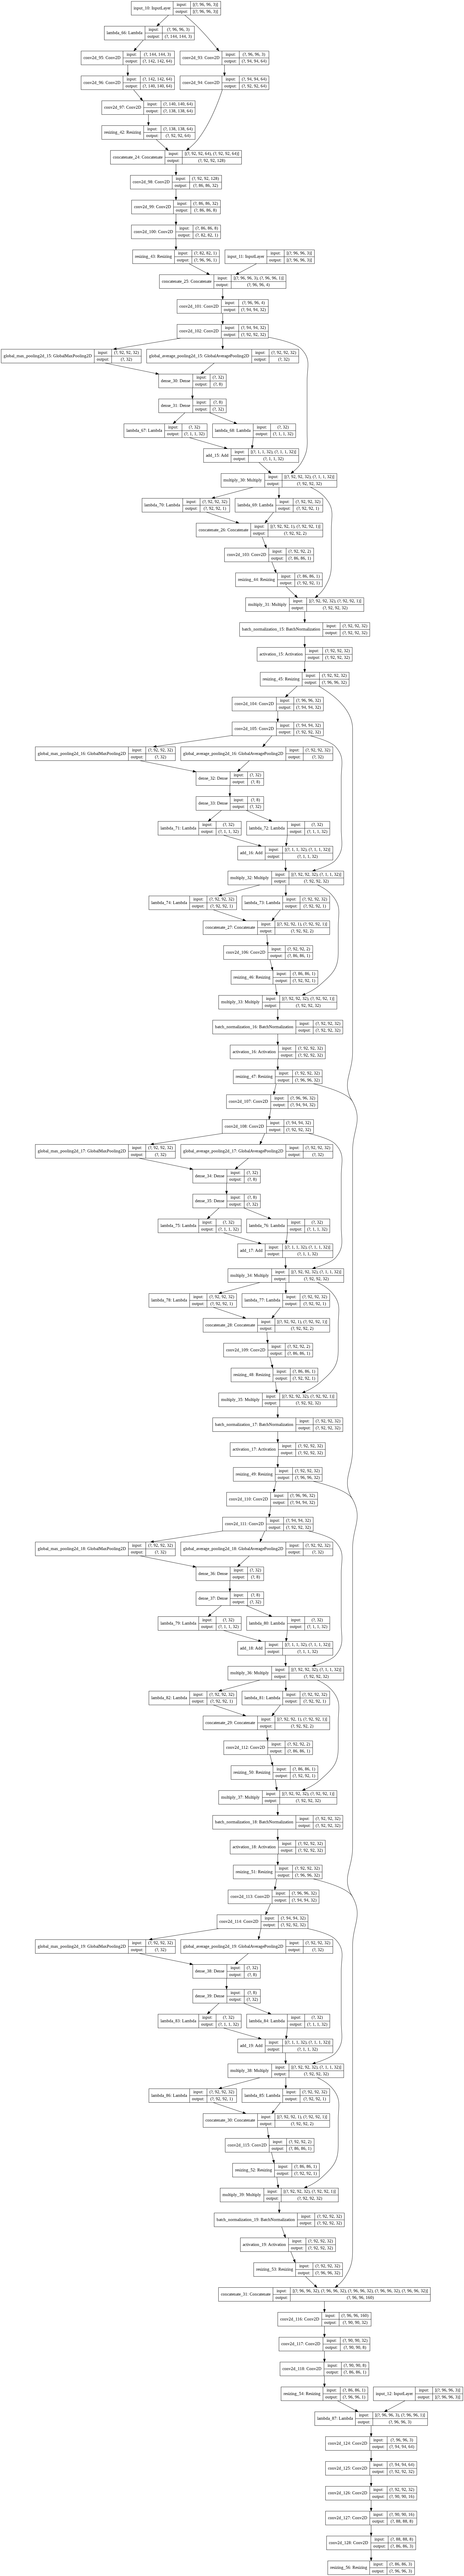

In [373]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

# Model Compile

In [374]:
model.compile(optimizer=keras.optimizers.Adam(),loss=custom_loss_wrapper(input_layer_1),metrics=[keras.metrics.MSE])

In [375]:

img_high.shape

(1485, 96, 96, 3)

# Model Fitting

In [376]:
tf.config.run_functions_eagerly(True)


In [377]:
model.fit(x=[img_low,img_low,img_low],y=[img_high],epochs=1,batch_size=7)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


213/213 [==============================] - 65s 305ms/step - loss: 80.0250 - mean_squared_error: 0.0331


In [378]:
model.fit(x=[img_low,img_low,img_low],y=[img_high],epochs=10,batch_size=7)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
213/213 [==============================] - 65s 304ms/step - loss: 79.5978 - mean_squared_error: 0.0328
Epoch 2/10
213/213 [==============================] - 65s 305ms/step - loss: 79.3845 - mean_squared_error: 0.0326
Epoch 3/10
213/213 [==============================] - 65s 305ms/step - loss: 79.1549 - mean_squared_error: 0.0324
Epoch 4/10
213/213 [==============================] - 65s 305ms/step - loss: 79.1874 - mean_squared_error: 0.0324
Epoch 5/10
213/213 [==============================] - 65s 305ms/step - loss: 79.1887 - mean_squared_error: 0.0325
Epoch 6/10
213/213 [==============================] - 65s 304ms/step - loss: 78.6579 - mean_squared_error: 0.0320
Epoch 7/10
213/213 [==============================] - 65s 305ms/step - loss: 78.5651 - mean_squared_error: 0.0320
Epoch 8/10
213/213 [==============================] - 65s 304ms/step - loss: 78.4548 - mean_squared_error: 0.0319
Epoch 9/10
213/213 [==============================] - 65s 303ms/step - loss: 78.3395 - m

In [283]:
model.fit(x=[img_low,img_low,img_low],y=[img_high],epochs=10,batch_size=7)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
213/213 [==============================] - 53s 250ms/step - loss: 78.1151 - mean_squared_error: 0.0319
Epoch 2/10
213/213 [==============================] - 53s 249ms/step - loss: 80.0309 - mean_squared_error: 0.0344
Epoch 3/10
213/213 [==============================] - 53s 249ms/step - loss: 78.7037 - mean_squared_error: 0.0324
Epoch 4/10
213/213 [==============================] - 53s 249ms/step - loss: 78.3595 - mean_squared_error: 0.0321
Epoch 5/10
213/213 [==============================] - 53s 249ms/step - loss: 78.1054 - mean_squared_error: 0.0319
Epoch 6/10
213/213 [==============================] - 53s 249ms/step - loss: 78.0349 - mean_squared_error: 0.0319
Epoch 7/10
213/213 [==============================] - 53s 249ms/step - loss: 77.5754 - mean_squared_error: 0.0314
Epoch 8/10
213/213 [==============================] - 53s 250ms/step - loss: 77.6651 - mean_squared_error: 0.0316
Epoch 9/10
213/213 [==============================] - 53s 250ms/step - loss: 77.1154 - m

In [284]:
model.fit(x=[img_low,img_low,img_low],y=[img_high],epochs=10,batch_size=7)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
213/213 [==============================] - 53s 249ms/step - loss: 77.1081 - mean_squared_error: 0.0311
Epoch 2/10
213/213 [==============================] - 53s 248ms/step - loss: 76.8286 - mean_squared_error: 0.0310
Epoch 3/10
213/213 [==============================] - 53s 249ms/step - loss: 76.7207 - mean_squared_error: 0.0308
Epoch 4/10
213/213 [==============================] - 53s 249ms/step - loss: 76.5149 - mean_squared_error: 0.0306
Epoch 5/10
213/213 [==============================] - 53s 250ms/step - loss: 76.6598 - mean_squared_error: 0.0307
Epoch 6/10
213/213 [==============================] - 53s 249ms/step - loss: 76.5294 - mean_squared_error: 0.0306
Epoch 7/10
213/213 [==============================] - 53s 249ms/step - loss: 114.5829 - mean_squared_error: 1.2470
Epoch 8/10
213/213 [==============================] - 53s 249ms/step - loss: 80.1686 - mean_squared_error: 0.0336
Epoch 9/10
213/213 [==============================] - 53s 249ms/step - loss: 79.1120 - 

In [357]:
model

In [379]:
img=np.expand_dims(img_low[7],axis=0)

In [380]:

img.shape

(1, 96, 96, 3)

In [381]:
a=model.predict(x=[img,img,img])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [382]:
import matplotlib.pyplot as plt


In [383]:
a

array([[[[0.45855334, 0.43586555, 0.4116326 ],
         [0.45207414, 0.42130217, 0.38794652],
         [0.45171863, 0.40870234, 0.3811464 ],
         ...,
         [0.4610545 , 0.3999033 , 0.37040895],
         [0.46462658, 0.40811747, 0.37080967],
         [0.4567232 , 0.40176255, 0.36142012]],

        [[0.4535349 , 0.4325463 , 0.40077046],
         [0.44212997, 0.41531652, 0.37329552],
         [0.4428268 , 0.3987419 , 0.36387083],
         ...,
         [0.46431375, 0.40400645, 0.37311098],
         [0.46510905, 0.40910524, 0.3679047 ],
         [0.4531326 , 0.39808673, 0.3544276 ]],

        [[0.45749843, 0.43177965, 0.39002872],
         [0.44234058, 0.41259047, 0.3656905 ],
         [0.4409815 , 0.3960155 , 0.3548251 ],
         ...,
         [0.4659234 , 0.40563646, 0.3741882 ],
         [0.46449345, 0.40745232, 0.36488956],
         [0.45113042, 0.39292714, 0.34786165]],

        ...,

        [[0.64997405, 0.6481537 , 0.63127244],
         [0.62944335, 0.6275219 , 0.6032136 ]

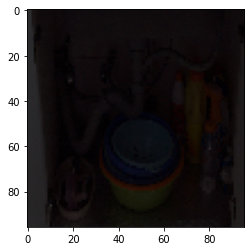

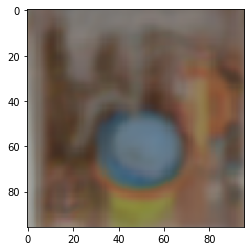

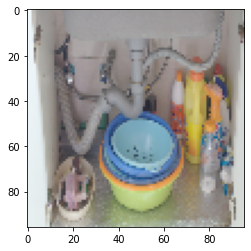

In [384]:
plt.imshow(img[0])
plt.show()
plt.imshow(a[0])
plt.show()
plt.imshow(img_high[7])
plt.show()

In [282]:


!nvidia-smi

Mon Nov  9 15:13:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    77W / 149W |  10868MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------